In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)

%matplotlib inline

* Recidivism is the tendency for an individual who has previously committed a crime to commit another crime in the future.

### The findings of the Pro Publica article:

* Black defendants were often predicted to be at a higher risk of recidivism than they actually were.

* White defendants were often predicted to be less risky than they were.

* When controlling for prior crimes, future recidivism, age, and gender, black defendants were 45 percent more likely to be assigned higher risk scores than white defendants.

* Black defendants were twice as likely as white defendants to be misclassified as being a higher risk of violent recidivism.

* Even when controlling for prior crimes, future recidivism, age, and gender, black defendants were 77 percent more likely to be assigned higher risk scores than white defendants.

In [2]:
data_url = "https://raw.githubusercontent.com/propublica/compas-analysis"
data_url += "/master/compas-scores-two-years.csv"

df = pd.read_csv(data_url)
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


* first: An individual’s first name

* last: An individual’s last name

* sex: An individual’s sex

* age: An individual’s age

* race: An individual’s race. It takes values of Caucasian, Hispanic, African-American, Native American, Asian, or Other

* priors_count: Number of previous arrests

* decile_score: The COMPAS risk score

* two_year_recid: Whether the individual had been jailed for a new crime in next two years



# Descriptive Statistics

In [3]:
race_count = df.groupby(["race"])["name"].count()
at_least_500 = list(race_count[race_count > 500].index)
print("The following race have at least 500 observations:", at_least_500)
df = df.loc[df["race"].isin(at_least_500), :]

The following race have at least 500 observations: ['African-American', 'Caucasian', 'Hispanic']


In [4]:
def create_groupcount_barplot(df, group_col, figsize, **kwargs):
    "call df.groupby(group_col), then count number of records and plot"
    counts = df.groupby(group_col)["name"].count().sort_index()

    fig, ax = plt.subplots(figsize=figsize)
    counts.plot(kind="bar", **kwargs)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("")

    return fig, ax

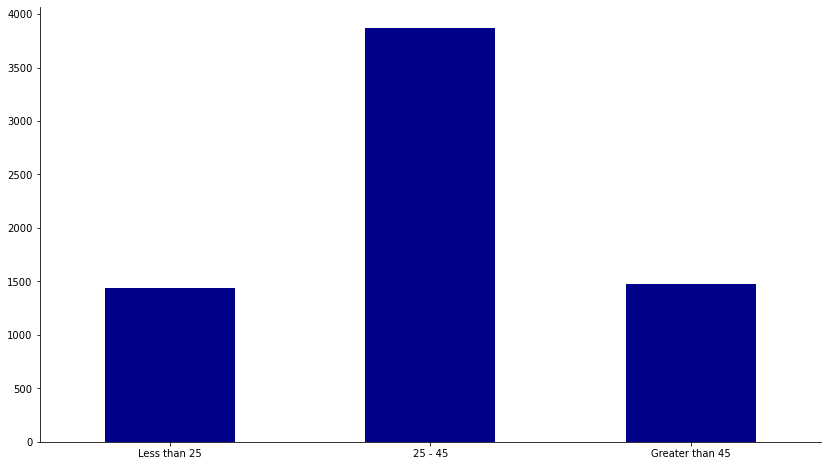

In [5]:
age_cs = ["Less than 25", "25 - 45", "Greater than 45"]
df["age_cat"] = pd.Categorical(df["age_cat"], categories=age_cs, ordered=True)
fig, ax = create_groupcount_barplot(df, "age_cat", (14, 8), color="DarkBlue", rot=0)

(<Figure size 432x576 with 1 Axes>, <AxesSubplot:>)

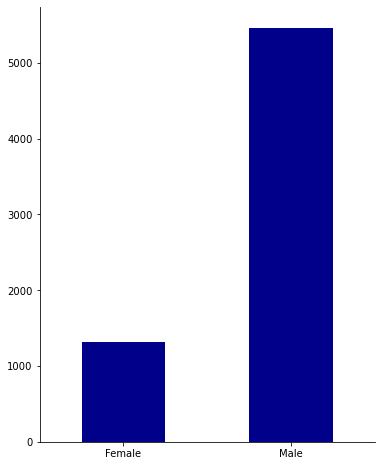

In [6]:
sex_cs = ["Female", "Male"]
df["sex"] = pd.Categorical(df["sex"], categories=sex_cs, ordered=True)
create_groupcount_barplot(df, "sex", (6, 8), color="DarkBlue", rot=0)

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

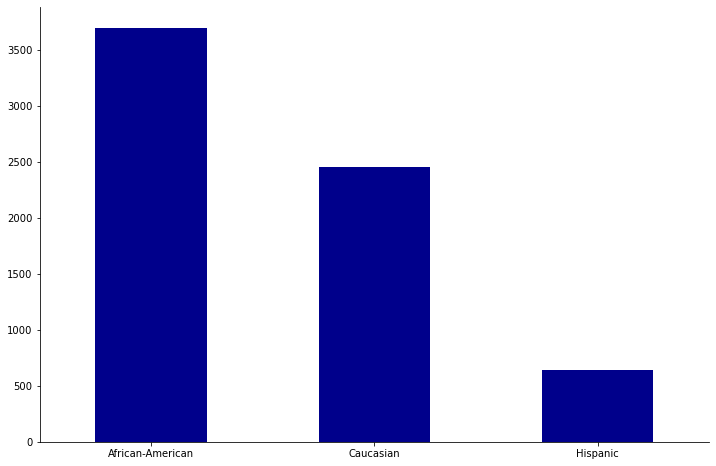

In [7]:
race_cs = ["African-American", "Caucasian", "Hispanic"]
df["race"] = pd.Categorical(df["race"], categories=race_cs, ordered=True)
create_groupcount_barplot(df, "race", (12, 8), color="DarkBlue", rot=0)

* From this, we learn that our population is mostly between 25-45, male, and is mostly African-American or Caucasian.



### Recidivism¶

In [8]:
recid = df.groupby(["age_cat", "sex", "race"])["two_year_recid"].mean().unstack(level="race")
recid

race                    African-American  Caucasian  Hispanic
age_cat         sex                                          
Less than 25    Female          0.449704   0.310345  0.411765
                Male            0.645806   0.541254  0.536364
25 - 45         Female          0.382278   0.423948  0.333333
                Male            0.533074   0.433699  0.375000
Greater than 45 Female          0.227273   0.239766  0.217391
                Male            0.425101   0.289157  0.216667